# Analyze a phagophore-vacuole peak-shaped contact

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN
import pandas as pd



import pyvista as pv
from pyvistaqt import BackgroundPlotter


# Import custom functions
dir_utilities = Path('../utilities').resolve().as_posix()
if dir_utilities not in sys.path:
    sys.path.insert(0, dir_utilities)
    
from utility_functions import load_segmentation_tif
from mesh_functions import extract_mesh_cell_ids, mesh_find_borders
from contact_analysis_functions import (peak_at_border, analyze_base_mesh, analyze_ph_vac_peak, 
                                        plot_map_and_slices_gridspec)
from histogram_functions import histogram_1d_values
from fitting_functions import plane_axes, project_points_on_plane, circle_fit_3d_points

## Input

In [2]:
# Input data
dir_in = Path('../example_data/phagophore_vacuole_contact')

fname_ph = dir_in / 'Phagophore_mesh.vtp'
fname_vac = dir_in / 'vacuole_contact_labels.tif'

pix_size = 1.408 # in nm


In [3]:
# Plot settings
window_size_0 = [512,512]
cpos = {'contact': [(735.900785431001, 1098.1984499153364, -138.61776691458243),
                      (228.23745949962404, 645.8410974571023, 181.56776119269168),
                      (0.20354445030098528, -0.7074748255008458, -0.6767931944355068)],
        'peak': [(320.3759903280495, 1101.7280419319454, 51.12171604683083),
              (278.22756328522786, 623.6983989861083, 198.12120238862911),
              (-0.04122983925795928, -0.29035481618862385, -0.9560304289460839)]}

## Load & preprocess data

In [4]:
# Vacuole: from segmentation tif file
p_tmp = load_segmentation_tif(fname_vac.as_posix(), {'seg': 1})
vac_points = p_tmp['seg']

# Phagophore: mesh generated with Pycurv, containing curvature info
ph_surf0 = pv.read(fname_ph)
# Get distance ph - vac
tree_vac = cKDTree(vac_points)
ph_surf0['vac_dist_pix'], idx_ph_vac = tree_vac.query(ph_surf0['xyz'])
print('Closest distance to vacuole: {:.2f} nm.'.format(min(ph_surf0['vac_dist_pix'])*pix_size))


Closest distance to vacuole: 10.17 nm.


In [5]:
# Cut phagophore mesh to allow separation into outer and inner membrane

cutoff = 100 # cutoff distance to vacuole in pixels
ids_keep = np.where(ph_surf0['vac_dist_pix']<=cutoff)[0]
ph_surf1 = extract_mesh_cell_ids(ph_surf0, ids_keep, keep_cells=True)

# Get connected regions
ph_surf1['connected_region_id'] = ph_surf1.connectivity().cell_arrays['RegionId']
unique_region_ids = np.unique(ph_surf1['connected_region_id'])
print('Unique region ids: {}'.format( unique_region_ids))

Unique region ids: [0 1]


In [6]:
# Determine which of the connected regions is the outer/inner phagophore membrane by checking distance to vacuole
region_min_vacdist = [np.min(ph_surf1['vac_dist_pix'][ph_surf1['connected_region_id']==i]) for i in unique_region_ids]
[id_out, id_in] = np.argsort(region_min_vacdist)  
    
# Save the outer and inner phagophore mesh
ph_surf_out = extract_mesh_cell_ids(ph_surf1, np.where(ph_surf1['connected_region_id']==id_out)[0], keep_cells=True)
ph_surf_in = extract_mesh_cell_ids(ph_surf1, np.where(ph_surf1['connected_region_id']==id_in)[0], keep_cells=True)

# Get distance from outer to inner membrane
tree_in = cKDTree(ph_surf_in['xyz'])
ph_surf_out['imdist_pix'],_ = tree_in.query(ph_surf_out['xyz'])
ph_surf_out['imdist_nm'] = ph_surf_out['imdist_pix']*pix_size

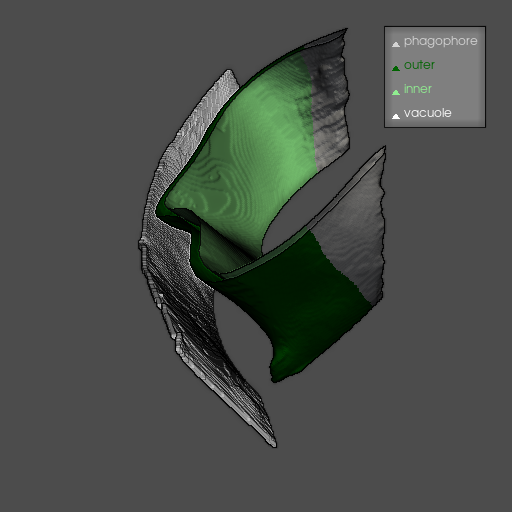

In [7]:
# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()
p0.add_mesh(ph_surf0, color='lightgrey', label='phagophore')
p0.add_mesh(ph_surf_out, color='darkgreen', label='outer')
p0.add_mesh(ph_surf_in, color='lightgreen', label='inner')
p0.add_mesh(vac_points, color='white', label='vacuole')
p0.add_legend()
p0.camera_position = cpos['contact']
_ = p0.show()
p0.close()

## Find peaks in the outer membrane

Having tested different parameters, the parameter that works best (also for less prominent peaks) for us is the product of the gaussian curvature with the distance of the outer to the inner membrane.

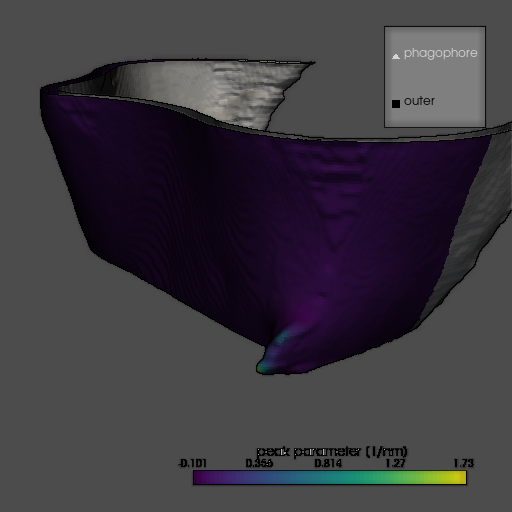

In [8]:
# Parameter for finding peaks: product of gaussian curvature and distance to inner membrane
peak_parameter = ph_surf_out['gauss_curvature_VV']*ph_surf_out['imdist_nm']
cutoff = np.mean(peak_parameter) + 3*np.std(peak_parameter) # in a normal distribution, 99.7% of values are within 3 sigma of mean

# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()
p0.add_mesh(ph_surf0, color='lightgrey', label='phagophore')
p0.add_mesh(ph_surf_out, scalars=peak_parameter, label='outer')
p0.add_scalar_bar('peak parameter [1/nm]')
#p0.add_mesh(vac_points, color='white', label='vacuole')
p0.add_legend()
p0.camera_position = cpos['peak']
_ = p0.show()
p0.close()

Found 1 clusters.
0 out of 1 peaks are at the border of the segmentation.


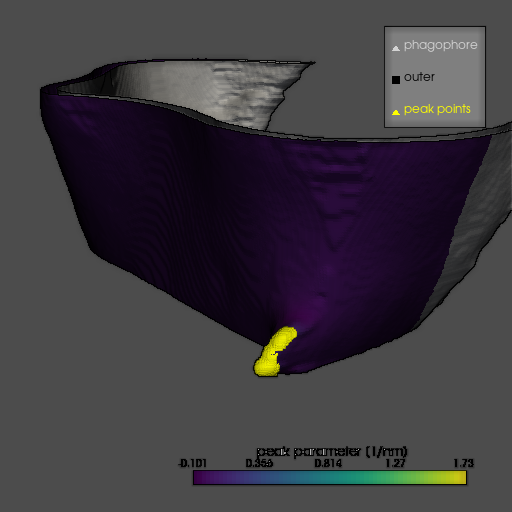

In [9]:
# Find peak points

# Get id, point coordinates and distances to original border
idx_peak = np.where(peak_parameter > cutoff)[0]    
points_peak = ph_surf_out['xyz'][idx_peak]
dist_to_border = ph_surf_out['dist_to_orig_border'][idx_peak]

# Cluster points using DBSCAN
cluster_labels = DBSCAN(eps=10).fit_predict(points_peak)
unique_labels, unique_counts = np.unique(cluster_labels, return_counts=True)
print('Found {} clusters.'.format(len(unique_labels)))

# Check if peaks are at the border of the segmented area
border_peak = peak_at_border(dist_to_border, cluster_labels, unique_labels)
print('{} out of {} peaks are at the border of the segmentation.'.format(sum(border_peak),len(unique_labels)))
if np.all(border_peak):
    print('All found peaks are at the border.')

# Save results
peakdict = {'peak_point_ids': idx_peak,
             'peak_points': points_peak,
             'peak_labels': cluster_labels,
             'peak_labels_unique': (unique_labels, unique_counts),
             'peak_at_border': border_peak}

# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()
p0.add_mesh(ph_surf0, color='lightgrey', label='phagophore')
p0.add_mesh(ph_surf_out, scalars=peak_parameter, label='outer')
p0.add_scalar_bar('peak parameter [1/nm]')
p0.add_mesh(points_peak, color='yellow', label='peak points')
p0.add_legend()
p0.camera_position = cpos['peak']
_ = p0.show()
p0.close()

### Extract the full peak surface

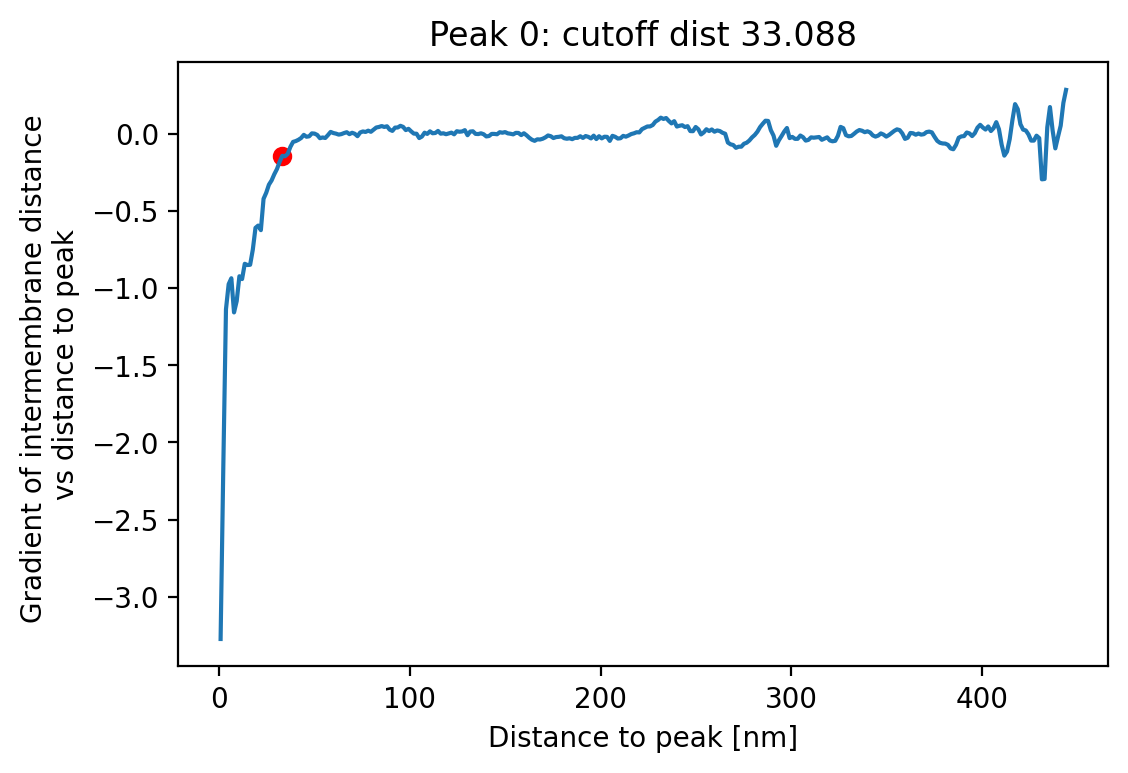

In [10]:
# Get the full peak surface(s)
peak_surfs = {}
peak_full_ids = {}
all_peak_ids = np.array([])

# Settings for getting the cutoff distance
bin_step = pix_size
cutoff_grad_value = -0.15

for i, label in enumerate(peakdict['peak_labels_unique'][0]):
    if peakdict['peak_at_border'][i]:
        # If peak is a border peak, remove points from mesh for calculating baseline but don't process otherwise
        peak_ids = peakdict['peak_point_ids'][peakdict['peak_labels']==label]
        all_peak_ids = np.concatenate((all_peak_ids, peak_ids), axis=0)
        continue
    points = peakdict['peak_points'][peakdict['peak_labels']==label]
    tree_peak = cKDTree(points)
    dist_peak_pix, _ = tree_peak.query(ph_surf_out['xyz'])
    dist_peak_nm = dist_peak_pix*pix_size

    # Find distance cutoff by checking how imdist falls off when going away from peak
    
    # Make 1D histogram of inter-membrane distance vs distance to peak and get its derivative
    hist, hist_counts, hist_extent, bin_edges = histogram_1d_values(dist_peak_nm, ph_surf_out['imdist_nm'], 
                                                                    bin_step, return_bins=True)
    bin_middles = 0.5*(bin_edges[:-1]+bin_edges[1:])
    #hist, bin_middles, counts = weighted_histogram_1d(dist_peak_nm, surf_out['imdist_nm'], bin_step)
    hist_grad = np.gradient(hist, bin_step)
    # Apply cutoff
    cutoff_id = np.searchsorted(hist_grad, cutoff_grad_value)
    cutoff_dist = bin_middles[cutoff_id]

    # Plot
    fig, ax = plt.subplots(dpi=200)
    ax.plot(bin_middles, hist_grad)
    ax.scatter(cutoff_dist, hist_grad[cutoff_id], color='r')
    ax.set_title('Peak {}: cutoff dist {}'.format(i, cutoff_dist))
    ax.set_ylabel('Gradient of intermembrane distance \nvs distance to peak')
    ax.set_xlabel('Distance to peak [nm]')
    plt.show()

    # Get full peak
    full_peak_ids = np.where(dist_peak_nm <= cutoff_dist)[0]

    all_peak_ids = np.concatenate((all_peak_ids, full_peak_ids), axis=0)
    # Generate surface of the peak
    peak_key = 'peak{}'.format(i)
    peak_full_ids[peak_key] = full_peak_ids
    peak_surfs[peak_key] = extract_mesh_cell_ids(ph_surf_out, full_peak_ids, keep_cells=True)

    #plotter.add_mesh(peak_surfs[key][peak_key], color=cmap(i))

# For entire segmentation, generate mesh without peaks
all_peak_ids = np.unique(all_peak_ids)
peak_surfs['nopeak'] = extract_mesh_cell_ids(ph_surf_out, all_peak_ids.astype(int), keep_cells=False)

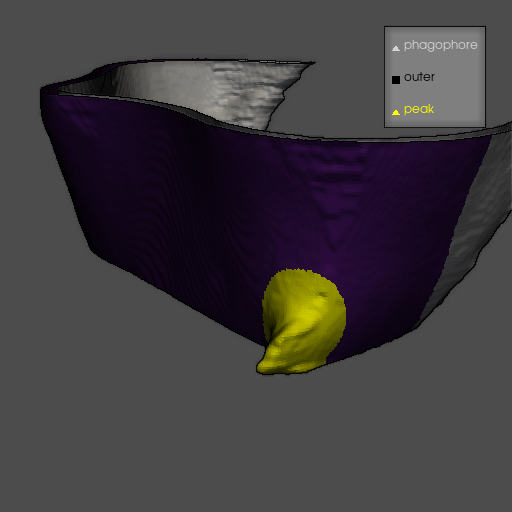

In [11]:
# Plot
p0 = pv.Plotter(notebook=True, window_size=window_size_0)
p0.enable_eye_dome_lighting()
p0.add_mesh(ph_surf0, color='lightgrey', label='phagophore')
p0.add_mesh(ph_surf_out, scalars=peak_parameter, label='outer')
p0.add_mesh(peak_surfs['peak0'], color='yellow', label='peak')
#p0.add_mesh(vac_points, color='white', label='vacuole')
p0.add_legend()
p0.camera_position = cpos['peak']
_ = p0.show()

## Analyze peak

In [12]:
# Analyze peaks
peak_results_list = []
# Parameters for which maximum value is calculated in each step
max_params = ['kappa_1', 'kappa_2', 'mean_curvature_VV', 'curvedness_VV']
min_height = pix_size

# Get keys for individual peak surfaces, excluding nopeak
peak_keys = [k for k in list(peak_surfs.keys()) if k.startswith('peak')]
# Calculate base values
base_vals = analyze_base_mesh(peak_surfs['nopeak'])

for key in peak_keys:
    # Analyze peak
    res_tmp = analyze_ph_vac_peak(peak_surfs[key], base_vals)
    # Peak should have at least the height of a pixel
    if res_tmp.height < min_height:
        continue
    # Calculate some more values
    max_vals = [np.max(peak_surfs[key][name]) for name in max_params]

    # Assemble full results list
    res_list = [key] + list(res_tmp) + max_vals + list(base_vals)
    peak_results_list.append(res_list)

    
# Save as pandas dataframe (useful for several peaks) ---------------------------------------
# Make column headers
base_names = ['base_{}'.format(name) for name in base_vals._fields]
max_param_names = ['max_{}'.format(name) for name in max_params]
col_headers = ['ID'] + list(res_tmp._fields) + max_param_names + base_names
        
# Make a pandas dataframe from the results
df_peaks = pd.DataFrame(peak_results_list, columns = col_headers)
df_peaks.set_index('ID', drop=True, inplace=True)

In [13]:
print(df_peaks.iloc[0])

area                       4.088449e+03
height                     3.321539e+01
width                      1.686224e+01
vac_dist_min_nm            2.189501e+01
vac_dist_peak_nm           2.208998e+01
dist_top_closest           1.035124e+00
dist_corr_pearson         -8.911522e-01
dist_corr_spearman        -8.555357e-01
E_bend_peak                6.600678e-19
E_bend_diff                6.389599e-19
E_bend_diff_kBT            1.526626e+02
max_kappa_1                2.148400e-01
max_kappa_2                1.920965e-01
max_mean_curvature_VV      1.972505e-01
max_curvedness_VV          1.974075e-01
base_area                  7.881945e+04
base_imdist                1.146599e+01
base_vac_dist              7.033282e+01
base_dist_corr_pearson    -3.515877e-01
base_dist_corr_spearman   -2.374152e-01
base_E_bend                4.069309e-19
Name: peak0, dtype: float64


### Create a map of the peak

In [14]:
# Get base planes and calculate plane dist and vac dist for each peak

d_peak_maps = {}

for key in df_peaks.index:

    # Get the peak mesh
    surf_tmp = peak_surfs[key].copy()
    # Get the plane & circle through the peak base
    border_verts,_,_ = mesh_find_borders(surf_tmp)
    border_points = surf_tmp.points[border_verts]
    border_circle = circle_fit_3d_points(border_points)
    print('{}: radius {:.1f} pixels, rmse {:.1f} pixels'.format(key,border_circle.radius, border_circle.rmse))
    # Project points into the circle plane
    plane_ax0, plane_ax1 = plane_axes(border_circle.normal)    
    # Step 2: Project points on the plane and get their coordinates with respect to the plane
    plane_points = project_points_on_plane(surf_tmp['xyz'], border_circle.center, #
                                           plane_ax0, plane_ax1, output_coord_sys='plane')
    # Calculate distance to plane
    plane_dist = abs(np.dot(border_circle.center - surf_tmp['xyz'], border_circle.normal))
    plane_dist_nm = plane_dist*pix_size
    # Distance to vacuole
    vac_dist_nm = surf_tmp['vac_dist_pix']*pix_size
    
    # Save in dictionary
    d_peak_maps[key] = {'plane_points': plane_points, 'plane_dist': plane_dist_nm, 'vac_dist': vac_dist_nm,
                        'plane_axes': [plane_ax0, plane_ax1], 'plane_center': border_circle.center, 
                        'plane_normal': border_circle.normal}

peak0: radius 20.0 pixels, rmse 1.8 pixels


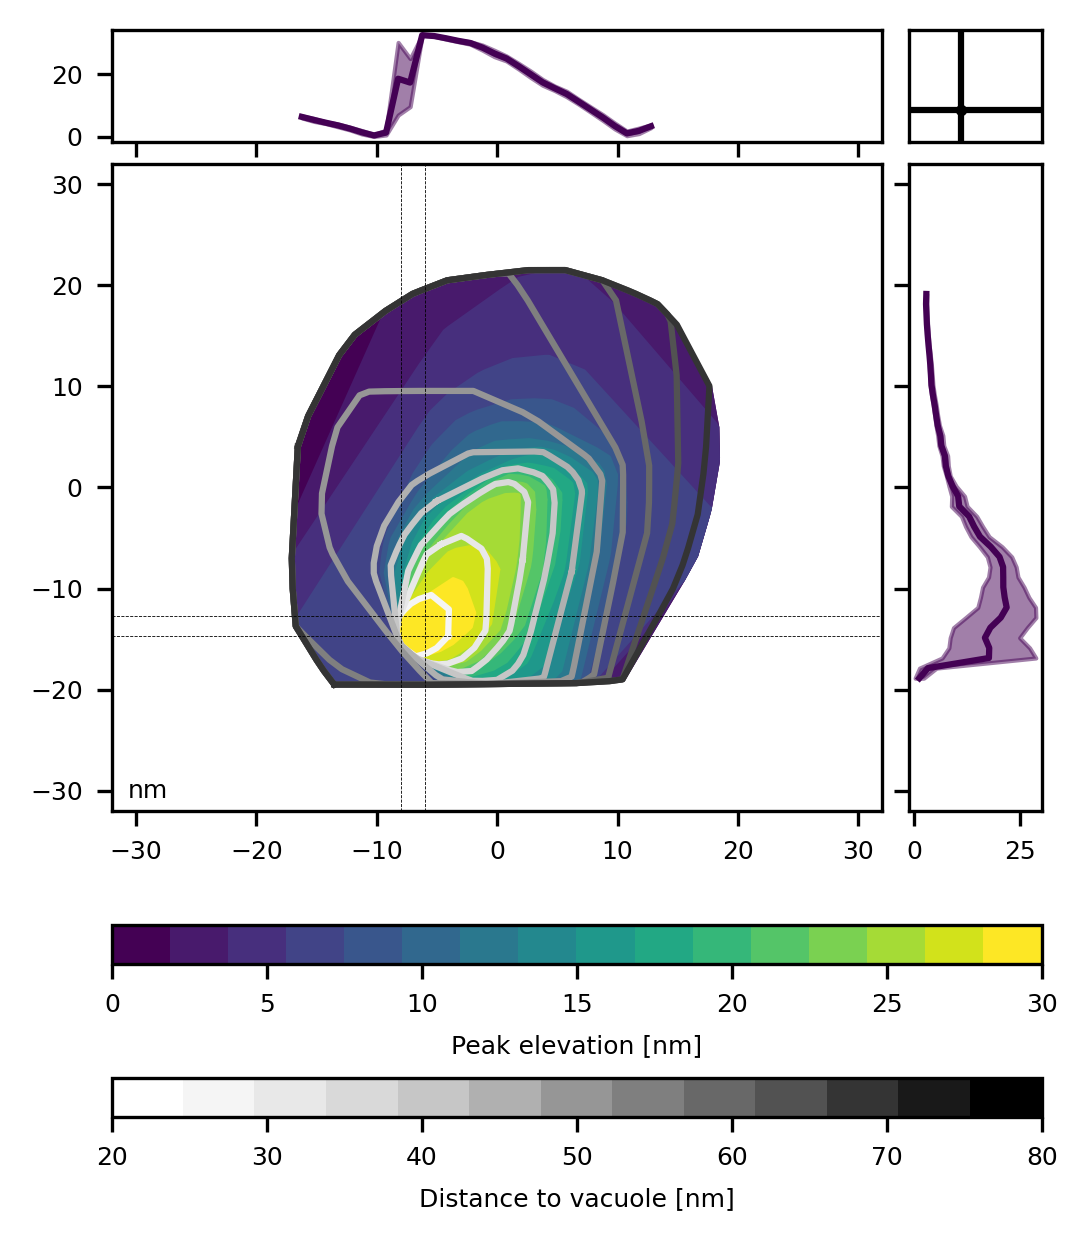

In [15]:
# Define steps and colormaps

# Distance to peak base plane: plot in color
pdist_steps = np.arange(0,32,2)   
pdist_cmap_name = 'viridis'
pdist_cmap = plt.cm.get_cmap(pdist_cmap_name, len(pdist_steps))

# Distance to vacuole: plot lines in greyscale
vdist_steps = np.arange(20,85,5)
vdist_cmap_name = 'Greys'
vdist_cmap = plt.cm.get_cmap(vdist_cmap_name, len(vdist_steps))

# Combine data into dictionaries    
d_tmp = d_peak_maps['peak0']
dist0 = {'values': d_tmp['plane_dist'], 'steps': pdist_steps, 'cmap': pdist_cmap}
dist1 = {'values': d_tmp['vac_dist'], 'steps': vdist_steps, 'cmap': vdist_cmap}

# Further plot settings
ax_limits = [-32,32]
slice_args= {'slice_thickness': 2, 'slice_steps': 1, 'color': pdist_cmap(0)}
map_len=4
scalar_bar_height = 0.2
plt.rcParams.update({'font.size': 6})

# Set up the figure: adjust for more peaks! --------------------------------------------------------
fig = plt.figure(dpi=300, figsize=(map_len,map_len+4*scalar_bar_height))
gs0 = gridspec.GridSpec(5, 1, figure=fig, height_ratios=[map_len]+4*[scalar_bar_height])

    
# Make the map & line plots
gs01 = gs0[0]
gs_tmp, list_ax = plot_map_and_slices_gridspec(fig, gs01, d_tmp['plane_points'], dist0, dist1, ax_limits, slice_args)        
list_ax[0].text(0.02,0.02,'nm', transform=list_ax[0].transAxes) # add unit into plot

# Add colorbars

# plane dist colorbar
ax_c0 = fig.add_subplot(gs0[-3,0])
pdist_norm = plt.Normalize(pdist_steps[0], pdist_steps[-1])
fig.colorbar(plt.cm.ScalarMappable(norm=pdist_norm, cmap=pdist_cmap), orientation='horizontal', 
             cax=ax_c0, label='Peak elevation [nm]')
# vac dist colorbar
ax_c1 = fig.add_subplot(gs0[-1,0])
vdist_norm = plt.Normalize(vdist_steps[0], vdist_steps[-1])
fig.colorbar(plt.cm.ScalarMappable(norm=vdist_norm, cmap=vdist_cmap), orientation='horizontal', 
             cax=ax_c1, label='Distance to vacuole [nm]')

plt.show()